Aim: calculating the average GC content of ORFs into which ISs insert themselves and compare it to the GC content of ORFs from the whole genome.

In [1]:
from Bio import SeqIO
from Bio.SeqFeature import SeqFeature, FeatureLocation
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
%matplotlib inline

In [2]:
ref = "C:/Users/Flora/Desktop/M2 Systèmes Complexes/Stage/Bioinfo/ref/"
data = "C:/Users/Flora/Desktop/M2 Systèmes Complexes/Stage/Bioinfo/LTEE-clone-curated/"

In [3]:
record = SeqIO.read(ref+'REL606.gbk', 'genbank') #loading ancestor reference file

In [4]:
def extract_positions(IS_name):
    '''Generates a dictionary listing the position of insertions that occured at some point in at least
    one of the clones of one of the populations (only one occurrence per position, even if it occured
    in different populations).'''

    
    from os import listdir
    from os.path import isfile, join
    onlyfiles = [f for f in listdir(data) if isfile(join(data, f))] #listing all file names for the .gd files
    files = [] # creating a list that will first contain these names to be called, and later on open .gd files
    file_names = [] # list that will contain names as strings (kept as such for all the analysis)
    readlines_names = [] #list that will contain lists with the lines of each file (obtained via readlines())
    for i in onlyfiles: #fixing an error in the list of files (I don't know why it occurs) and filling the previously defined lists
        if len(i) < 30:
            files.append(i)
            file_names.append(i)
            readlines_names.append(i)
    
    
    for i in range(len(files)):
        files[i] = open(data+files[i],"r") #the list files becomes a list of open files
        readlines_names[i] = files[i].readlines() # the list readlines_names becomes a list of lists, with each list containing 
        #all the lines from one file
    
    
    insertion_positions = {} # Creating a dictionary to hold the positions of the insertions
    for i in range(len(file_names)): # for each file
        for line in readlines_names[i]: #we look at all the lines in the corresponding readlines_names entry
            line = line.split()
            if 'MOB' in line and IS_name in line: #if the line corresponds to a mutation linked to the IS
                insertion_positions[line[4]] = [line[4], line[6]] #we add an entry for this IS position to our dictionary
                # and save the orientation as well
                # /!\ this will erase the previous insertion if there was already an insertion at this position
    
    return insertion_positions
    

In [5]:
def calc_gc_content(sequence):
    """Return the % G+C content in a passed sequence.
    Arguments:
        - sequence  - a Bio.Seq.Seq object.
    calc_gc_content(sequence)
    """
    d = {}
    for nt in ["A", "T", "G", "C"]:
        d[nt] = sequence.count(nt) + sequence.count(nt.lower())
    gc = d.get("G", 0) + d.get("C", 0)

    if gc == 0:
        return 0
    # print(gc*100.0/(d['A'] +d['T'] + gc))
    return gc * 1.0 / (d["A"] + d["T"] + gc)

In [6]:
def GC_content(IS_name):
    '''Returns a list of the GC content of CDS into which an IS has inserted.'''

    positions_IS = extract_positions(IS_name) # generating a dictionary of the format {insertion_position: [position, orientation]}
    gc_content_list = [] # initializing the GC content list

    for insertion_position in list(positions_IS.keys()): #for each insertion
        IS_position = int(insertion_position) #we get the insertion position as an integer
        position_found = False

        for feature in record.features[1:]: #for each feature in the reference genome
            if feature.type == 'CDS': # if the feature is a coding sequence
                if 'join' not in str(feature.location): #getting rid of an annoying but unique anomaly in the features
                    start_position = int(str(feature.location).split(':')[0][1:]) # getting the start position of the CDS
                    end_position = int(str(feature.location).split(':')[1][:-4]) # getting the end position of the CDS
                    if IS_position >= start_position and IS_position <= end_position: # if the IS interrupts that CDS
                        position_found = True
                        gc_content = calc_gc_content(record[start_position:end_position].seq)
                        # we calculate the GC content in the CDS
                        gc_content_list.append(gc_content) #we save it in our list

    
    return gc_content_list


In [7]:
# calculating the GC content of all CDS in the genome
gc_content_CDS = []
for feature in record.features[1:]:
    if 'join' not in str(feature.location) and feature.type == 'CDS': #getting rid of an annoying but unique anomaly in the features
        start_position = int(str(feature.location).split(':')[0][1:])
        end_position = int(str(feature.location).split(':')[1][:-4])
        gc_content = calc_gc_content(record[start_position:end_position].seq)
        gc_content_CDS.append(gc_content)

In [8]:
GC_content_IS150 = GC_content('IS150')

In [9]:
len(GC_content_IS150)

221

Plotting the distribution of GC content of ORF in the genome (with the mean in red):

Text(0.5, 0, 'GC content')

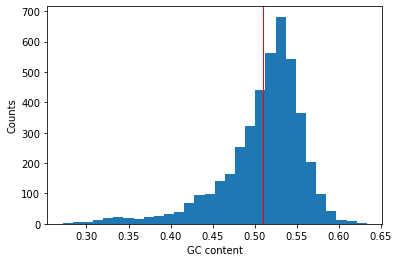

In [10]:
plt.hist(gc_content_CDS, density=False, bins=30)  # density=False makes counts
plt.axvline(sum(gc_content_CDS)/len(gc_content_CDS), color='red', linewidth=1)
plt.ylabel('Counts')
plt.xlabel('GC content')

Plotting the comparison between GC content in the genome and GC content of ORF targeted by IS150:

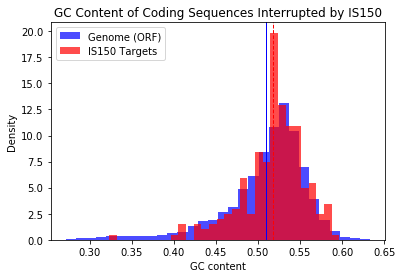

In [28]:
plt.hist(gc_content_CDS, density=True, bins=30, color = 'blue', alpha = 0.7, label = 'Genome (ORF)')  # density=False would make counts
plt.hist(GC_content_IS150, density=True, bins=30, color = 'red', alpha = 0.7, label = 'IS150 Targets')  # density=False would make counts
plt.axvline(sum(gc_content_CDS)/len(gc_content_CDS), color='blue', linewidth=1)
plt.axvline(sum(GC_content_IS150)/len(GC_content_IS150), color='red', linestyle='dashed', linewidth=1)
plt.ylabel('Density')
plt.xlabel('GC content')
plt.legend()
plt.title('GC Content of Coding Sequences Interrupted by IS150')

plt.savefig('GC_content_IS150_CDS.png',dpi=400)

Plotting the comparison between GC content in the genome and GC content of ORF targeted by IS1:

In [12]:
GC_content_IS1 = GC_content('IS1')

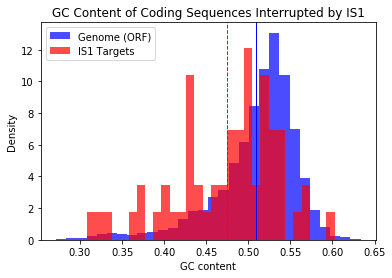

In [27]:
plt.hist(gc_content_CDS, density=True, bins=30, color = 'blue', alpha = 0.7, label = 'Genome (ORF)')  # density=False would make counts
plt.hist(GC_content_IS1, density=True, bins=30, color = 'red', alpha = 0.7, label = 'IS1 Targets')  # density=False would make counts
plt.axvline(sum(gc_content_CDS)/len(gc_content_CDS), color='blue', linewidth=1)
plt.axvline(sum(GC_content_IS1)/len(GC_content_IS1), color='red', linestyle='dashed', linewidth=1)
plt.ylabel('Density')
plt.xlabel('GC content')
plt.legend()
plt.title('GC Content of Coding Sequences Interrupted by IS1')
plt.savefig('GC_content_IS1_CDS.png',dpi=400)

Plotting the comparison between GC content in the genome and GC content of ORF targeted by IS186:

In [14]:
GC_content_IS186 = GC_content('IS186')

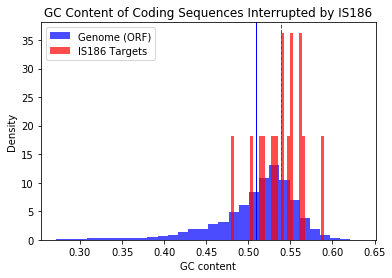

In [26]:
plt.hist(gc_content_CDS, density=True, bins=30, color = 'blue', alpha = 0.7, label = 'Genome (ORF)')  # density=False would make counts
plt.hist(GC_content_IS186, density=True, bins=30, color = 'red', alpha = 0.7, label = 'IS186 Targets')  # density=False would make counts
plt.axvline(sum(gc_content_CDS)/len(gc_content_CDS), color='blue', linewidth=1)
plt.axvline(sum(GC_content_IS186)/len(GC_content_IS186), color='red', linestyle='dashed', linewidth=1)
plt.ylabel('Density')
plt.xlabel('GC content')
plt.legend()
plt.title('GC Content of Coding Sequences Interrupted by IS186')
plt.savefig('GC_content_IS186_CDS.png',dpi=400)

# Statistical tests

t-test to compare the two distributions

In [16]:
import scipy.stats
from scipy.stats import ttest_ind, ttest_ind_from_stats

IS1:

In [17]:
t, p = ttest_ind(gc_content_CDS, GC_content_IS1, equal_var=False)
p

7.116459775457067e-05

IS150:

In [18]:
t, p = ttest_ind(gc_content_CDS, GC_content_IS150, equal_var=False)
p

0.0016640462446754546

IS186:

In [19]:
t, p = ttest_ind(gc_content_CDS, GC_content_IS186, equal_var=False)
p

0.0009230894981788921